## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [3]:


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [4]:
def cal_undistort (img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None, None)
    undist = cv2.undistort(img,mtx,dist, None, mtx)
    return undist

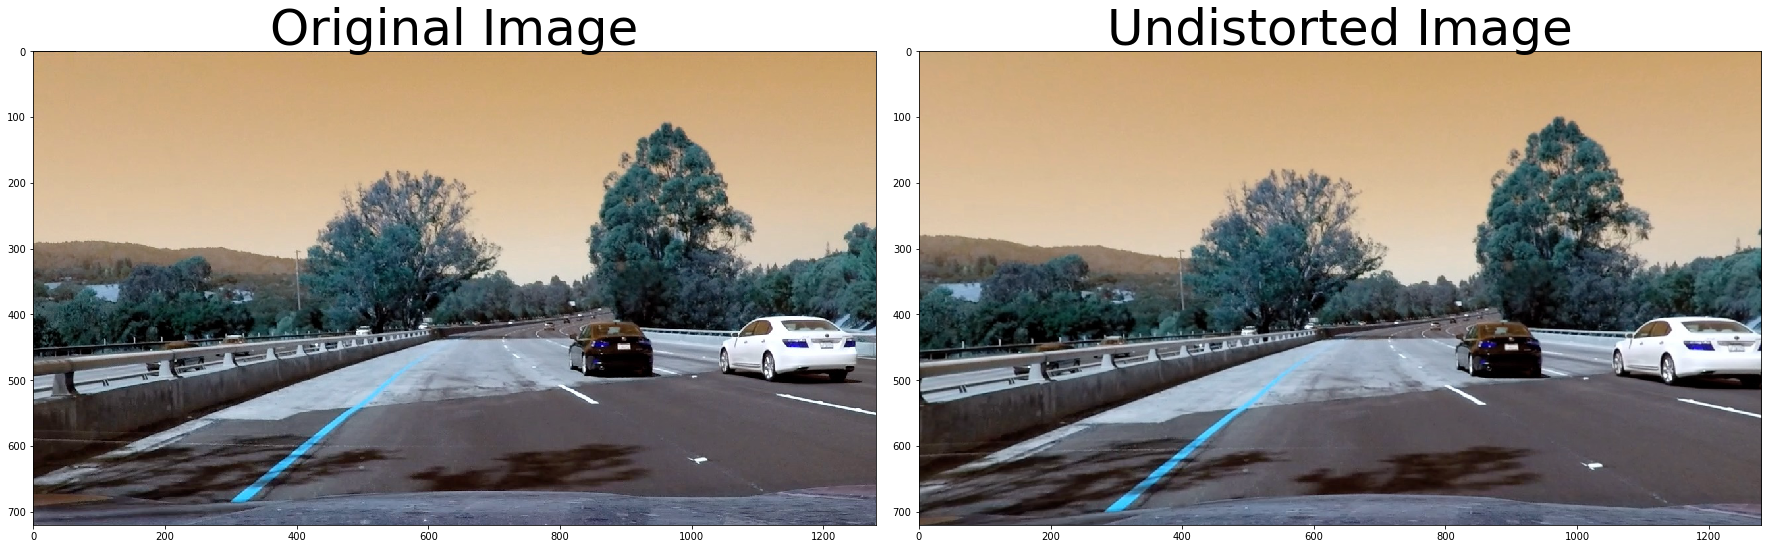

In [5]:
images_test = cv2.imread('../test_images/test4.jpg')

undistorted = cal_undistort(images_test, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(images_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

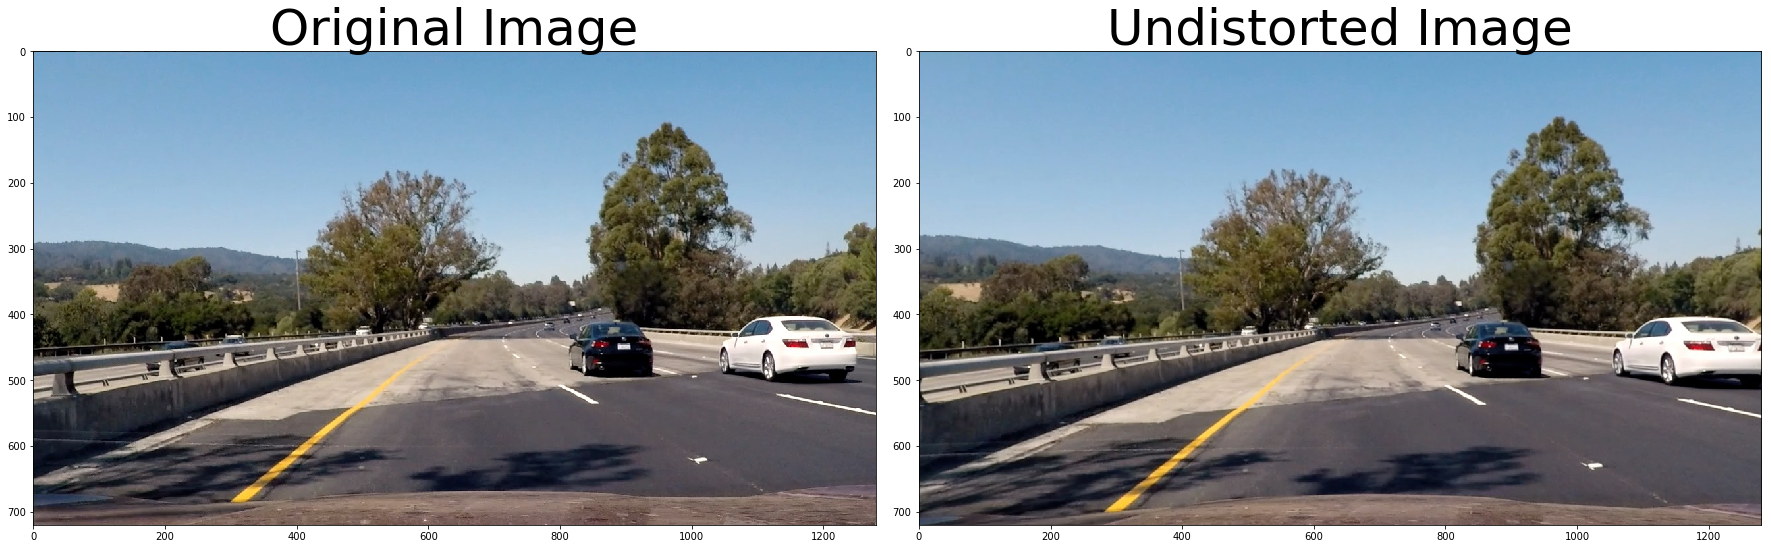

In [6]:
image_test = cv2.imread('../test_images/test4.jpg')

undistorted = cal_undistort(images_test, objpoints, imgpoints)
image_test_RGB = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
undistorted_RGB = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test_RGB)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_RGB)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

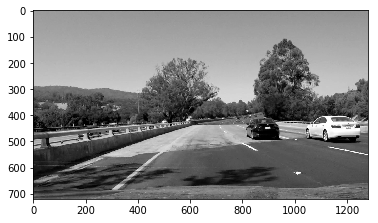

In [7]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

image_test_2 = cv2.imread('../test_images/test4.jpg')
gray = grayscale(image_test_2)
plt.imshow(gray, cmap="gray")

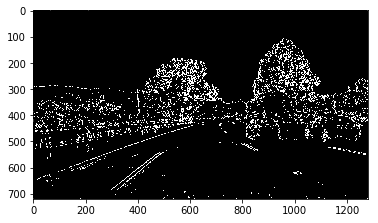

In [8]:

# Calculate the derivative in the xx direction (the 1, 0 at the end denotes xx direction):
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
# Calculate the derivative in the yy direction (the 0, 1 at the end denotes yy direction):
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
# Calculate the absolute value of the x derivative:
abs_sobelx = np.absolute(sobelx)
#Convert the absolute value image to 8-bit:
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')


In [9]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255), sobel_kernel=3):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [10]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [11]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [12]:
def hls_threshold(img, thresh = (170, 255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)# use BGR when cv2.imread
    s_channel = hls[:,:,2]
    s_thresh_min = thresh[0]
    s_thresh_max = thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary

Text(0.5,1,'S channel Image')

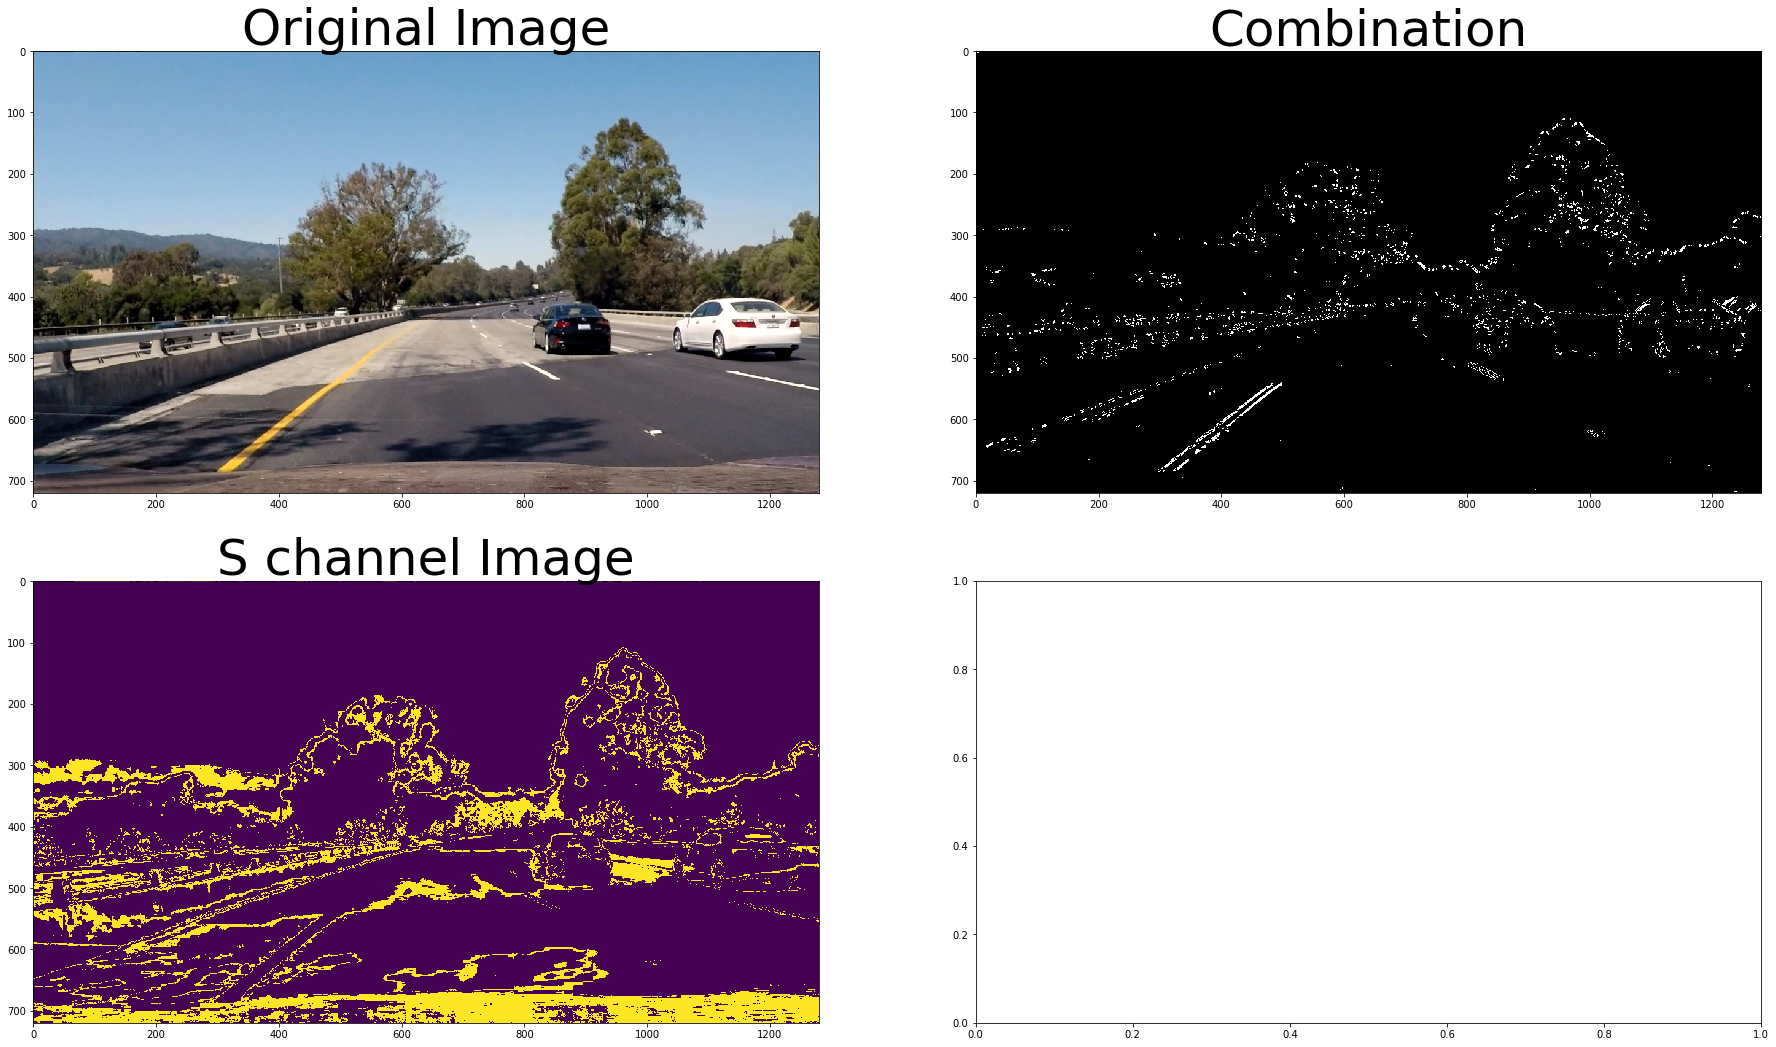

In [13]:

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image_test_2, orient='x', sobel_kernel=3, thresh=(40, 90))
grady = abs_sobel_thresh(image_test_2, orient='y', sobel_kernel=3, thresh=(40, 90))
mag_binary = mag_thresh(image_test_2, sobel_kernel=9, mag_thresh=(50, 100))
dir_binary = dir_threshold(image_test_2, sobel_kernel=15, thresh=(0.7, 1.2))

s_binary = hls_threshold(image_test_2, thresh=(23, 40))
#combination
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


image_test_2_RGB = cv2.cvtColor(image_test_2, cv2.COLOR_BGR2RGB)
# Plot the result
f, ([ax1, ax2],[ ax3, ax4]) = plt.subplots(2, 2, figsize=(24, 9))
#f.tight_layout()
ax1.imshow(image_test_2_RGB)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combination', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.5)
ax3.imshow(s_binary)
ax3.set_title('S channel Image', fontsize=50)

## 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

In [14]:
img_size = (1280, 720)
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])

src_int = np.int32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])

dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])

src




array([[ 580.     ,  460.     ],
       [ 203.33333,  720.     ],
       [1126.6666 ,  720.     ],
       [ 705.     ,  460.     ]], dtype=float32)

In [15]:
dst

array([[320.,   0.],
       [320., 720.],
       [960., 720.],
       [960.,   0.]], dtype=float32)

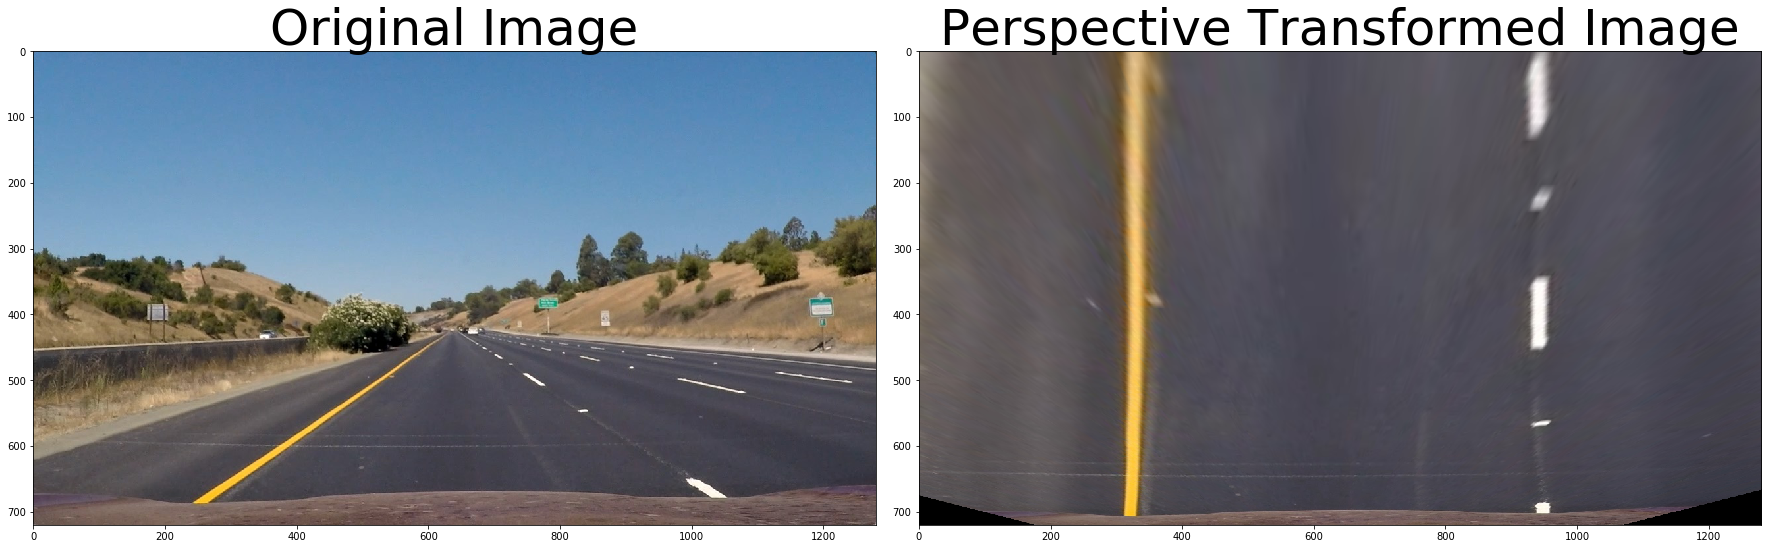

In [16]:
image_for_perspective = cv2.imread('../test_images/straight_lines1.jpg')

image_for_perspective_RGB = cv2.cvtColor(image_for_perspective, cv2.COLOR_BGR2RGB)
#image_for_perspective_RGB_roi = cv2.polylines(image_for_perspective_RGB,[src_int],True,(0,255,255))
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(image_for_perspective_RGB, M, (1280, 720),flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_for_perspective_RGB)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Perspective Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Text(0.5,1,'Warped Image')

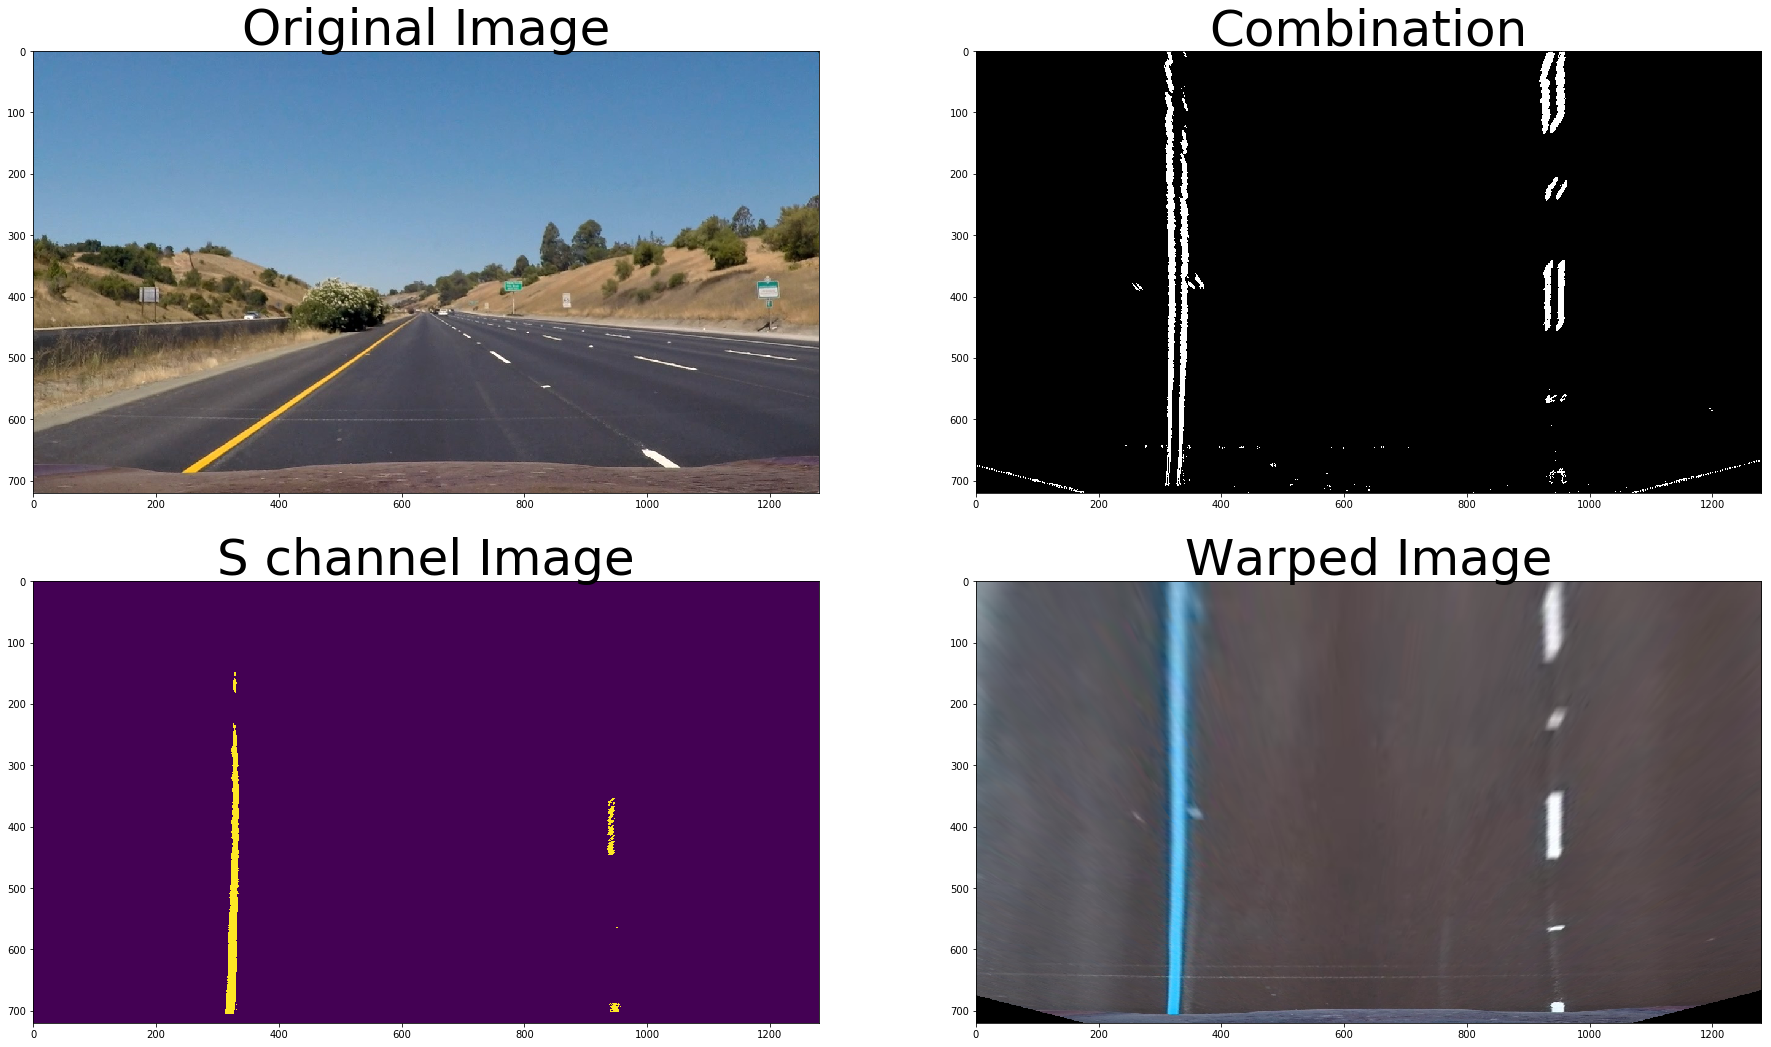

In [17]:
image_for_perspective = cv2.imread('../test_images/straight_lines1.jpg')

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(image_for_perspective, M, (1280, 720),flags=cv2.INTER_LINEAR)

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=3, thresh=(20, 110))
grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=3, thresh=(20, 110))
mag_binary = mag_thresh(warped, sobel_kernel=9, mag_thresh=(30, 150))
dir_binary = dir_threshold(warped, sobel_kernel=15, thresh=(0.7, 1.3))

s_binary = hls_threshold(warped, thresh=(200, 255))
#combination
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

image_RGB = cv2.cvtColor(image_for_perspective, cv2.COLOR_BGR2RGB)
# Plot the result
f, ([ax1, ax2],[ ax3, ax4]) = plt.subplots(2, 2, figsize=(24, 9))
#f.tight_layout()
ax1.imshow(image_RGB)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combination', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.5)
ax3.imshow(s_binary)
ax3.set_title('S channel Image', fontsize=50)
ax4.imshow(warped, cmap = 'gray')
ax4.set_title('Warped Image', fontsize=50)

## 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?


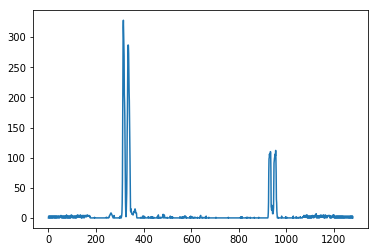

In [18]:
#take a histogram along all the columns in the lower half of the image like this:
import numpy as np
img = combined.copy()
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

Text(0.5,1,'Warped Image')

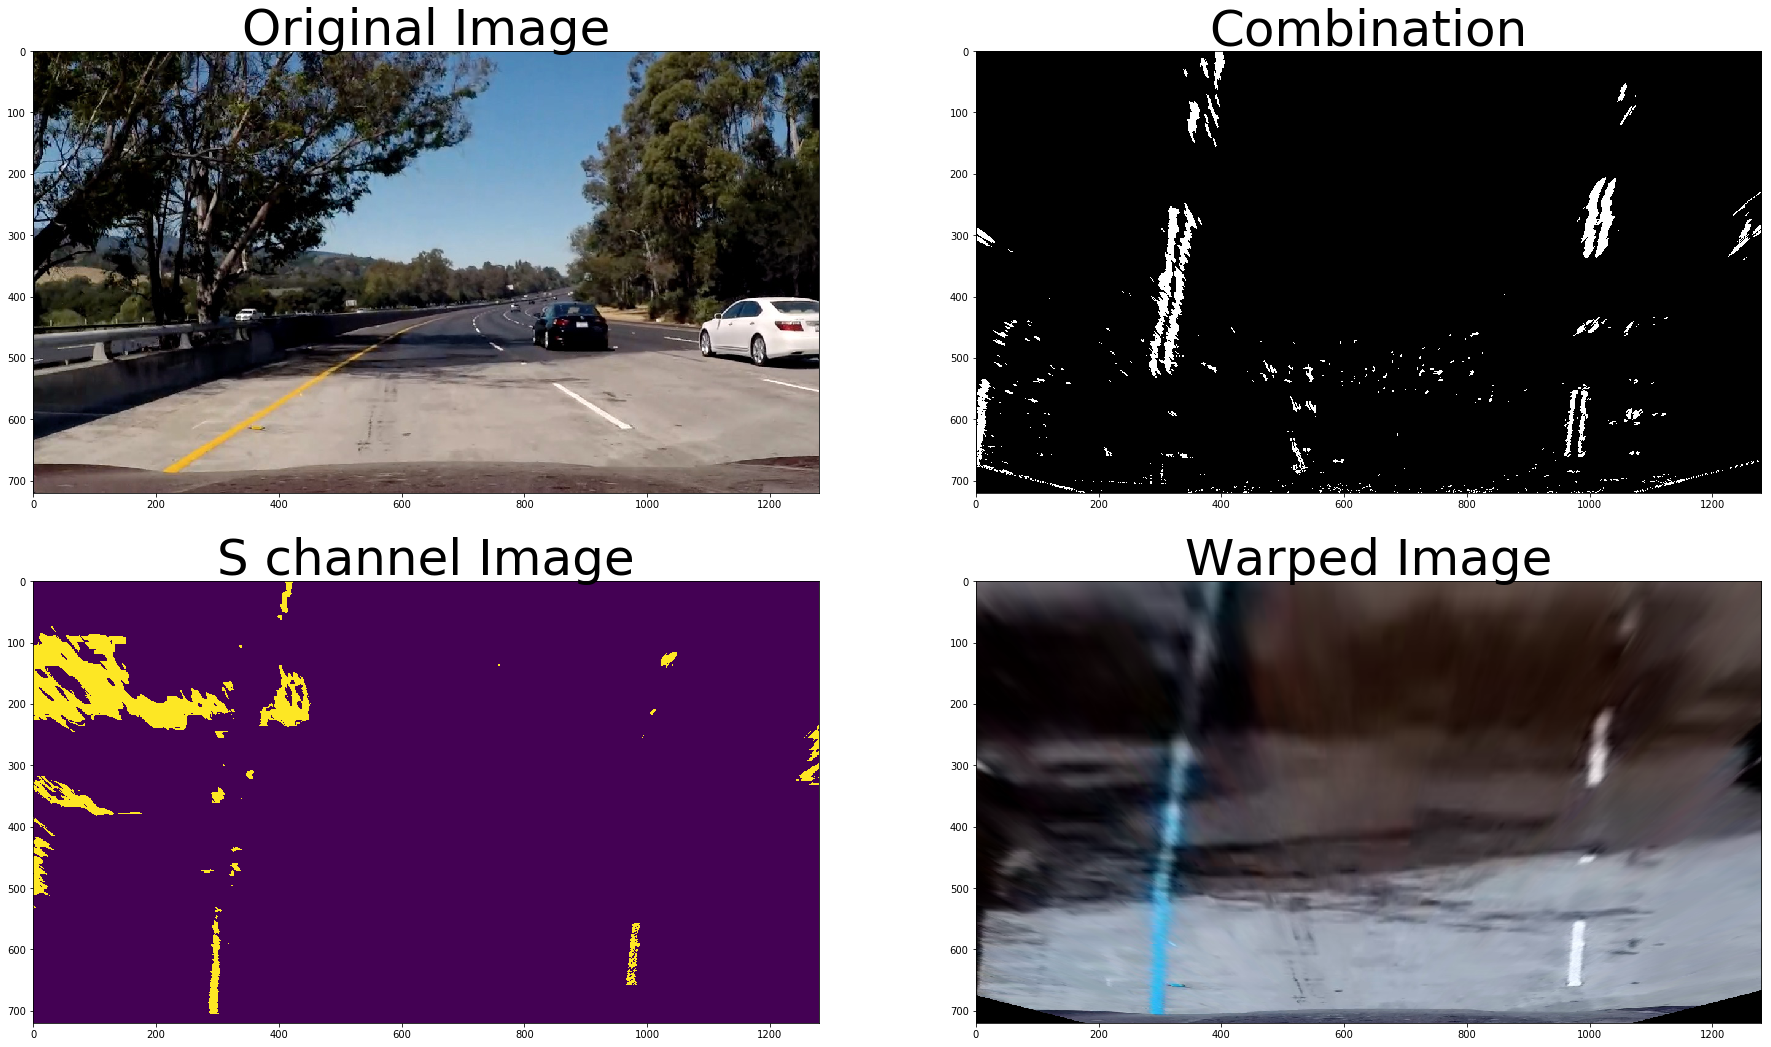

In [19]:
image_for_perspective = cv2.imread('../test_images/test5.jpg')

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(image_for_perspective, M, (1280, 720),flags=cv2.INTER_LINEAR)

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=3, thresh=(20, 110))
grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=3, thresh=(20, 110))
mag_binary = mag_thresh(warped, sobel_kernel=9, mag_thresh=(30, 150))
dir_binary = dir_threshold(warped, sobel_kernel=15, thresh=(0.7, 1.3))

s_binary = hls_threshold(warped, thresh=(190, 255))
#combination
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

image_RGB = cv2.cvtColor(image_for_perspective, cv2.COLOR_BGR2RGB)
# Plot the result
f, ([ax1, ax2],[ ax3, ax4]) = plt.subplots(2, 2, figsize=(24, 9))
#f.tight_layout()
ax1.imshow(image_RGB)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combination', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.5)
ax3.imshow(s_binary)
ax3.set_title('S channel Image', fontsize=50)
ax4.imshow(warped, cmap = 'gray')
ax4.set_title('Warped Image', fontsize=50)

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = combined.copy()
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 0)

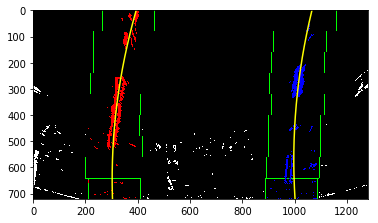

In [21]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )# to gent x value: Return evenly spaced numbers over a specified interval. (start , stop, number)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [22]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 0)

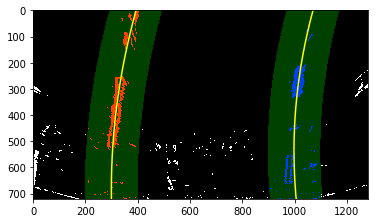

In [23]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.001, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

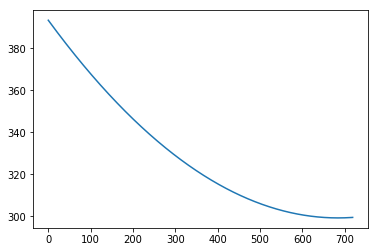

In [24]:
plt.plot(left_fitx)

## 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [25]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print('radius of curvature in pixels: Left: ',left_curverad,', Right: ', right_curverad)
# Example values: 1926.74 1908.48

radius of curvature in pixels: Left:  2489.4610390237685 , Right:  2012.3469768724983


In [26]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700# meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

In [27]:
# Calculate the new radii of curvature
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

817.4391594799627 m 652.8856362299331 m


In [28]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/(right_fitx[-1] - left_fitx[-1]) # meters per pixel in x dimension

# Assuming the camera is mounted at the center of the vehicle. Car_position = middle of image
car_position = 1280/2
lane_center_pixel = (right_fitx[-1] + left_fitx[-1]) /2
center_dist = (car_position - lane_center_pixel) * xm_per_pix
print('Position of the vehicle with respect to center:', center_dist, 'm')

Position of the vehicle with respect to center: -0.06633818674373113 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 0)

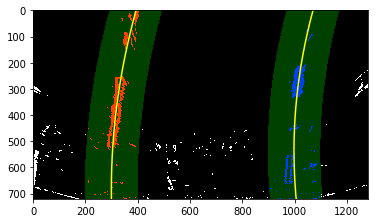

In [29]:
# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.001, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Reference:

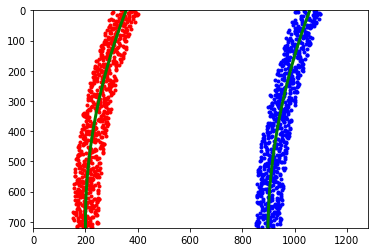

In [30]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [31]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1577.8240025548466 1741.1791692168845


In [32]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

518.1337482705907 m 571.6817089673249 m


## 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [33]:
M

array([[-4.97112153e-01, -1.48336989e+00,  9.39605691e+02],
       [-3.60822483e-15, -1.98605857e+00,  9.13586944e+02],
       [-2.81892565e-18, -2.38498308e-03,  1.00000000e+00]])

In [34]:
from numpy.linalg import inv
Minv = inv(M)

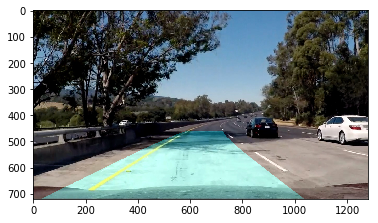

In [35]:


# Create an image to draw the lines on
warp_zero = np.zeros_like(combined).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image_RGB.shape[1], image_RGB.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image_RGB, 1.0, newwarp, 0.3, 0)
plt.imshow(result)

## 7. Pipeline (video)
### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).



In [36]:
# Perspective Transform
image_size = (1280, 720)
# src = np.float32(
#     [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
#     [((img_size[0] / 6) - 10), img_size[1]],
#     [(img_size[0] * 5 / 6) + 60, img_size[1]],
#     [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])

src_int = np.int32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])

dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])

#Function for Perspective Transform
def perspective_transform(image_for_perspective, src, dst, image_size=(1280, 720)):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = inv(M)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image_for_perspective, M, image_size,flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


In [37]:
def hls_threshold(img, thresh = (170, 255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)# use BGR when cv2.imread
    channel = hls[:,:,1]
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary = np.zeros_like(channel)
    binary[(channel >= thresh_min) & (channel <= thresh_max)] = 1
    return binary

In [38]:
# Define a function that thresholds the B-channel of LAB
# B channel should capture yellows
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [39]:
# Apply each of the thresholding functions
def thresholding_process(warped_img):
    #gradx = abs_sobel_thresh(warped_img, orient='x', sobel_kernel=3, thresh=(50, 130))
    #grady = abs_sobel_thresh(warped_img, orient='y', sobel_kernel=3, thresh=(20, 110))
    #mag_binary = mag_thresh(warped_img, sobel_kernel=9, mag_thresh=(30, 150))
    #dir_binary = dir_threshold(warped_img, sobel_kernel=15, thresh=(0.7, 1.3))

    l_binary = hls_threshold(warped_img, thresh=(210, 255))
    
    b_binary = lab_bthresh(warped_img)
    #combination
    combined = np.zeros_like(dir_binary)
    combined[((l_binary == 1))| (b_binary == 1)] = 1
    #if use cv2.imread, note to convert BGR to RGB
    #image_RGB = cv2.cvtColor(image_for_perspective, cv2.COLOR_BGR2RGB)
    return combined

In [40]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
def pipeline(img, objpoints, imgpoints, src, dst, image_size):
    # Undistort
    img_undistort = cal_undistort(img, objpoints, imgpoints)
    
    # Perspective Transform
    img_warped, M, Minv = perspective_transform(img_undistort, src, dst, image_size)

    combined = thresholding_process(img_warped)
    return combined, Minv

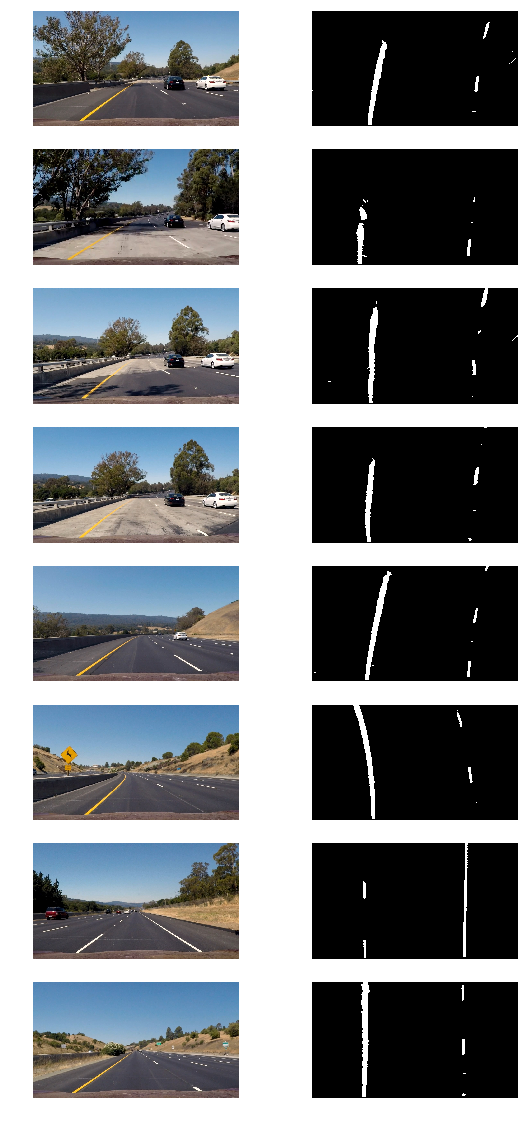

In [41]:
# Make a list of example images
images = glob.glob('../test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img, objpoints, imgpoints, src, dst, image_size)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

In [42]:
# Calculate radius of curvature and distance to center
def calculate_position(leftx, lefty, rightx, righty, right_fitx, left_fitx):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700# meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    # Now radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    curv_rad = (left_curverad+right_curverad)/2.0

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/(right_fitx - left_fitx) # meters per pixel in x dimension

    # Assuming the camera is mounted at the center of the vehicle. Car_position = middle of image
    car_position = 1280/2
    lane_center_pixel = (right_fitx + left_fitx) /2
    center_dist = (car_position - lane_center_pixel) * xm_per_pix
    #print('Position of the vehicle with respect to center:', center_dist, 'm')

    return curv_rad, center_dist

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def sliding_window_polyfit(img_combined):
    binary_warped = img_combined.copy()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # calculate position
    bottom_y = ploty[-1]
    left_fit_x = left_fit[0]*bottom_y**2 + left_fit[1]*bottom_y + left_fit[2]
    right_fit_x = right_fit[0]*bottom_y**2 + right_fit[1]*bottom_y + right_fit[2]
    curv_rad, center_dist = calculate_position(leftx, lefty, rightx, righty, right_fit_x, left_fit_x)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, curv_rad, center_dist

In [44]:
ploty[-1]

719.0

In [45]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

def last_fit_based_polyfit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # calculate position
    bottom_y = ploty[-1]
    left_fit_x = left_fit[0]*bottom_y**2 + left_fit[1]*bottom_y + left_fit[2]
    right_fit_x = right_fit[0]*bottom_y**2 + right_fit[1]*bottom_y + right_fit[2]
    curv_rad, center_dist = calculate_position(leftx, lefty, rightx, righty, right_fit_x, left_fit_x)
    
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, curv_rad, center_dist

In [46]:
binary_warped.shape[0]-1

719

In [47]:
# Create an image to draw the lines on
def unwarp_and_draw(image_RGB, binary_warped, Minv, left_fit, right_fit, curv_rad, center_dist):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image_RGB, 1.0, newwarp, 0.3, 0)
    
    # draw data of curvature radius and distance to center
    h = result.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    plt.imshow(result)
    
    return result

In [48]:
# test drawing function
#unwarp_and_draw(image_RGB, binary_warped, Minv, left_fitx, right_fitx, 333, 444)


In [49]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def line_update(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 100 or \
               self.diffs[1] > 100. or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # if there is not fit line, we will take it, otherwise abort this low quality fit
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or move one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [50]:
image_size

(1280, 720)

In [51]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img, objpoints, imgpoints, src, dst, image_size)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, curv_rad, center_dist = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds, curv_rad, center_dist = last_fit_based_polyfit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 650 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        #print('line difference', x_int_diff)
        if abs(650 - x_int_diff) > 300:
            l_fit = None
            r_fit = None
            
    l_line.line_update(l_fit, l_lane_inds)
    r_line.line_update(r_fit, r_lane_inds)
#     print('left Line:', l_fit)
#     print('right Line:', r_fit)
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out = unwarp_and_draw(new_img, img_bin, Minv, l_line.best_fit, r_line.best_fit, curv_rad, center_dist)
    else: 
        img_out = new_img 
    return img_out

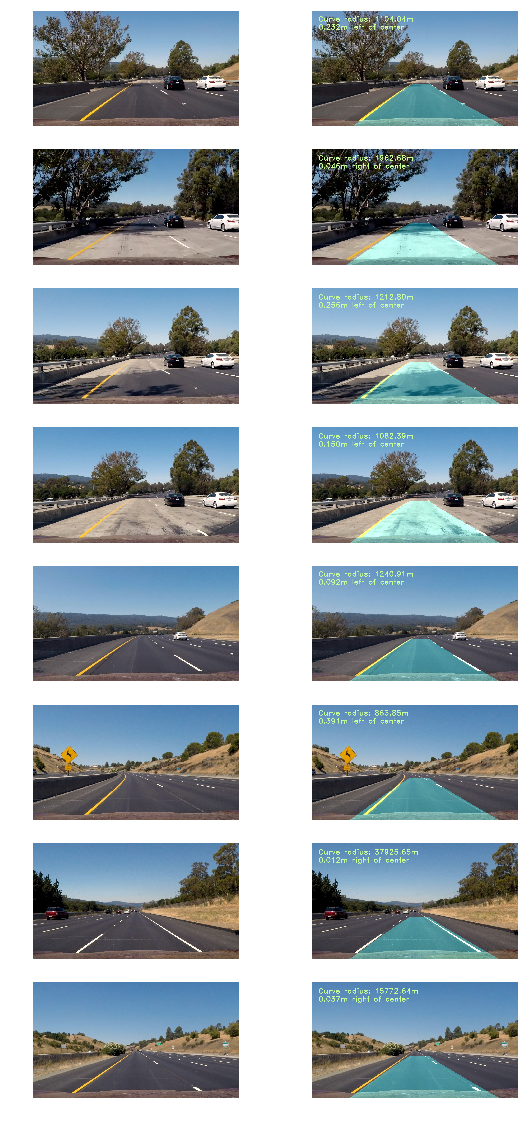

In [52]:
# Test process_image() :
l_line = Line()
r_line = Line()
# Make a list of example images
images = glob.glob('../test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin = process_image(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

In [53]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [15:22<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 17min 17s, sys: 52.4 s, total: 18min 10s
Wall time: 15min 24s


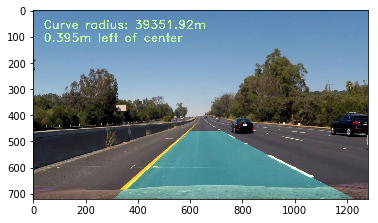

In [54]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = '../project_video_output.mp4'
video_input1 = VideoFileClip('../project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ../harder_challenge_video_output.mp4
[MoviePy] Writing video ../harder_challenge_video_output.mp4


100%|█████████▉| 250/251 [03:24<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../harder_challenge_video_output.mp4 

CPU times: user 3min 36s, sys: 13.4 s, total: 3min 50s
Wall time: 3min 27s


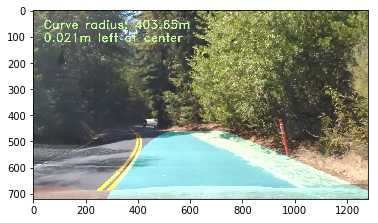

In [55]:
#hard version test
l_line = Line()
r_line = Line()
video_output3 = '../harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('../harder_challenge_video.mp4').subclip(0,10)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)